# Cats vs Dogs

The Kaggle competition Cats vs Dogs is a simple classification problem. I am given 10,000 images of Cats and Dogs, all labelled. The job is to train a model on these and then test how accurate my model is on the test set.

The top score as of 26 January 2018 is 99% accuracy.

On the competition's description:

>While random guessing is the easiest form of attack, various forms of image recognition can allow an attacker to make guesses that are better than random. There is enormous diversity in the photo database (a wide variety of backgrounds, angles, poses, lighting, etc.), making accurate automatic classification difficult. In an informal poll conducted many years ago, computer vision experts posited that a classifier with better than 60% accuracy would be difficult without a major advance in the state of the art. For reference, a 60% classifier improves the guessing probability of a 12-image HIP from 1/4096 to 1/459.

In [1]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!ls train | wc -l

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!ls test1 | wc -l

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import os
import shutil

In [5]:
train_path = "train"
test_path = "test1"

dogs = "train/dogs"
cats = "train/cats"

In [6]:
for file in os.listdir(train_path):
    if file.count('.') > 1:
        name_string = file.split('.')
        new_name = name_string[0] + name_string[1] + '.' + name_string[2]
        old_path = train_path + r'/' + file
        new_path = train_path + r'/' + new_name
        os.rename(old_path, new_path)

First goal of the project is to organize the data. I want to seperate the cats and dogs into two different folders for the training data.

Here I begin by defining the paths that I will be using to organize the data. I won't actually use the test path here yet but since I'm defining paths, I might as well define this right now.

After having imported some useful libraries when dealing with filepaths and file management, I begin by making sure that the file paths that I want actually exist.

In [7]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        print(directory + ' already exists')

create_directory(dogs)
create_directory(cats)

train/dogs already exists
train/cats already exists


Then I need to move every single file that has cats in it to the cats folder and every file that has dog in it to the dogs folder.

In [8]:
for file in os.listdir(train_path):
    current_file = train_path + '/' + file
    if 'dog' in current_file:
        shutil.move(current_file, dogs)
    elif 'cat' in current_file:
        shutil.move(current_file, cats)
    else:
        print(file)

In [9]:
!ls train/cats | wc -l

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
!ls train/dogs | wc -l

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
dogs[6:]

'dogs'

In [12]:
from sklearn.model_selection import train_test_split


def test_train_split(train_path, validation_path, animal):
    validation_path = validation_path + '/' + animal
    create_directory(validation_path)
    
    if len(os.listdir(train_path)) != 12500:
        print('Test data already split')
    else:
        # First I want to take a list of all the data
        # Then I want to split the data into two parts
        # One part will stay in the folder
        # The other part will be moved into a validation folder
        X = os.listdir(train_path)
        y = range(len(X))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)
        
        for file in X_test:
            # The path that was brought in will look like
            # train_path/(dogs)/(cats)/image####.jpg
            new_path = validation_path + '/' + file
            old_path = train_path + '/' + file
            shutil.move(old_path, new_path)

In [13]:
test_train_split(dogs, 'validation', 'dogs')
test_train_split(cats, 'validation', 'cats')

In [14]:
len(os.listdir('validation/dogs'))

2500

In [15]:
len(os.listdir('validation/cats'))

2500

# Training the Model

In [16]:
train_path = 'train'
validation_path = 'validation'

# Both cats and dogs should have the same number
train_num = len(os.listdir('train/dogs'))
validation_num = len(os.listdir('validation/dogs'))

epochs = 50
batch_size = 16

img_width, img_height = 150, 150

In [17]:
from keras import backend as K

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Using TensorFlow backend.


In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D # For cnn
from keras.layers import Activation, Dropout, Flatten, Dense # for neural networks in general

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss = 'binary_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

In [19]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_directory(train_path,
                                       target_size = (img_width, img_height),
                                       batch_size = batch_size,
                                       class_mode = 'binary')

validation_generator = datagen.flow_from_directory(validation_path,
                                                  target_size = (img_width, img_height),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [20]:
model.fit_generator(train_generator,
                   steps_per_epoch = train_num // batch_size,
                   epochs = epochs,
                   validation_data = validation_generator,
                   validation_steps = validation_num // batch_size)

Epoch 1/50
625/625 [==============================] - 336s 538ms/step - loss: 0.6544 - acc: 0.6178 - val_loss: 0.6354 - val_acc: 0.6366
Epoch 2/50
625/625 [==============================] - 250s 400ms/step - loss: 0.5705 - acc: 0.7122 - val_loss: 0.5412 - val_acc: 0.7224
Epoch 3/50
625/625 [==============================] - 221s 353ms/step - loss: 0.5297 - acc: 0.7419 - val_loss: 0.5639 - val_acc: 0.7002
Epoch 4/50
625/625 [==============================] - 222s 356ms/step - loss: 0.5120 - acc: 0.7629 - val_loss: 0.4888 - val_acc: 0.7748
Epoch 5/50
625/625 [==============================] - 200s 320ms/step - loss: 0.4639 - acc: 0.7869 - val_loss: 0.4826 - val_acc: 0.7761
Epoch 6/50
625/625 [==============================] - 238s 381ms/step - loss: 0.4802 - acc: 0.7842 - val_loss: 0.4162 - val_acc: 0.8153
Epoch 7/50
625/625 [==============================] - 220s 351ms/step - loss: 0.4518 - acc: 0.8042 - val_loss: 0.4194 - val_acc: 0.8272
Epoch 8/50
625/625 [============================

In [21]:
model.save('cats_vs_dogs.h5')

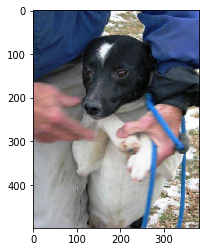

In [30]:
import numpy as np
from scipy.misc import imresize
from keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt

img = load_img('test1/1.jpg')
plt.imshow(img)
plt.show()

In [33]:
img = imresize(img, (img_width, img_height))
img = img_to_array(img)

img.shape

C:\Users\Thibault\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


(150, 150, 3)

In [35]:
img = np.expand_dims(img, axis = 0)
img.shape

(1, 150, 150, 3)

0 = Cat

1 = Dog

In [39]:
model.predict_classes(img)

array([[1]])